# Train Deep Learning Model

Building and training a multimodal deep learning model using PyTorch and Hugging Face Transformers.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch.optim as optim
from torchmetrics.regression import MeanAbsolutePercentageError, MeanAbsoluteError
from tqdm import tqdm
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/jovyan/environments/smda-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## Load Data

In [2]:
df = pd.read_parquet("smda/project/data/random_50000_scores_quality.parquet")

image_embedding_file = np.load("smda/project/data/image_embeddings.npz", allow_pickle=True)
image_embeddings = {k: image_embedding_file[k] for k in image_embedding_file.files}
title_embeddings = np.load("smda/project/data/title_embeddings.npz", allow_pickle=True)['arr_0'].item()

In [3]:
class VideoDataset(Dataset):
    def __init__(self, df, image_embeddings, title_embeddings):
        self.df = df
        self.image_embeddings = image_embeddings
        self.title_embeddings = title_embeddings

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = row['display_id']
        
        image_embedding = torch.tensor(self.image_embeddings[video_id], dtype=torch.float32)
        title_embedding = torch.tensor(self.title_embeddings[video_id], dtype=torch.float32)
        
        score = torch.tensor(row['quality_score'], dtype=torch.float32)
        
        return image_embedding, title_embedding, score

In [4]:
# create data split in train, validation and test set and create dataloader
def create_dataloaders(df, image_embeddings, title_embeddings, batch_size=32):
    dataset = VideoDataset(df, image_embeddings, title_embeddings)
    
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)
    
    train_dataset = VideoDataset(train_df, image_embeddings, title_embeddings)
    val_dataset = VideoDataset(val_df, image_embeddings, title_embeddings)
    test_dataset = VideoDataset(test_df, image_embeddings, title_embeddings)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

## Model Setup

In [5]:
# multimodal model
def get_mlp_layers(input_dim, output_dim, size='medium', for_submodel=True):
    # Fixed dropout rates
    dropout_sub = 0.3
    dropout_fc = 0.2
    dropout = dropout_sub if for_submodel else dropout_fc

    if size == 'small':
        layers = [
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)
        ]
    elif size == 'medium':
        layers = [
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        ]
    elif size == 'large':
        layers = [
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        ]
    else:
        raise ValueError("size must be 'small', 'medium', or 'large'")
    return nn.Sequential(*layers)

class SubModel(nn.Module):
    def __init__(self, input_dim, output_dim, size='large'):
        super(SubModel, self).__init__()
        self.fc = get_mlp_layers(input_dim, output_dim, size=size, for_submodel=True)

    def forward(self, x):
        return self.fc(x)

class MultimodalModel(nn.Module):
    def __init__(
        self,
        image_input_dim,
        text_input_dim,
        output_dim,
        submodel_size='medium',
        fc_size='medium'      
    ):
        super(MultimodalModel, self).__init__()
        self.image_model = SubModel(image_input_dim, 256, size=submodel_size)
        self.text_model = SubModel(text_input_dim, 256, size=submodel_size)
        self.fc = get_mlp_layers(512, output_dim, size=fc_size, for_submodel=False)

    def forward(self, image_x, text_x):
        image_out = self.image_model(image_x)
        text_out = self.text_model(text_x)
        combined = torch.cat((image_out, text_out), dim=1)
        return self.fc(combined)

## Train Setup

In [6]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.000001, path='checkpoint.pt', verbose=True,):
        """
        Early stops the training if validation loss doesn't improve after a given patience.

        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the model checkpoint.
            verbose (bool): If True, prints when saving a new best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model, epoch=None):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, epoch)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model, epoch)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch=None):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            if epoch is not None:
                print(f"Epoch {epoch+1}: Validation loss improved --> {val_loss:.6f}. Saving model...")
            else:
                print(f"Validation loss improved --> {val_loss:.6f}. Saving model...")

In [7]:
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, verbose=True):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []

        for image_embedding, title_embedding, target in train_loader:
            image_embedding, title_embedding, target = image_embedding.to(device), title_embedding.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(image_embedding, title_embedding)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        mean_train_loss = np.mean(batch_train_losses)
        train_losses.append(mean_train_loss)

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for image_embedding, title_embedding, target in val_loader:
                image_embedding, title_embedding, target = image_embedding.to(device), title_embedding.to(device), target.to(device)
                output = model(image_embedding, title_embedding)
                val_loss = criterion(output, target.view(-1, 1))
                batch_val_losses.append(val_loss.item())

        mean_val_loss = np.mean(batch_val_losses)
        val_losses.append(mean_val_loss)

        # Now, print and early stopping based on mean absolute percentage error
        if verbose:
            print(f'Epoch: {epoch+1}, Training Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}')

        early_stopper(mean_val_loss, model, epoch)
        if early_stopper.early_stop:
            if verbose:
                print("Early stopping triggered.")
                print(f"Best Validation loss: {early_stopper.best_loss:.4f}")
            break

    # Load the best model weights
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses

In [8]:
def evaluate_model_simple(model, data_loader, device, verbose=True):
    model.eval()
    mae_metric = MeanAbsoluteError().to(device)
    mape_metric = MeanAbsolutePercentageError().to(device)
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for image_embedding, title_embedding, target in data_loader:
            image_embedding = image_embedding.to(device)
            title_embedding = title_embedding.to(device)
            target = target.to(device)
            output = model(image_embedding, title_embedding).view(-1)
            all_targets.append(target.cpu().numpy())
            all_preds.append(output.cpu().numpy())
            mae_metric.update(output, target)
            mape_metric.update(output, target)

    mae = mae_metric.compute().item()
    mape = mape_metric.compute().item()
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    
    return mae, mape, all_targets, all_preds

## Hyperparameter Tuning with Optuna

In [10]:
model_path = "smda/project/models/multimodal_model_quality_optimized.pth"

def objective(trial):

    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_int("batch_size", 4, 32)
    submodel_size = trial.suggest_categorical("submodel_size", ["small", "medium", "large"])
    fc_size = trial.suggest_categorical("fc_size", ["small", "medium", "large"])
    
    title_dims = len(next(iter(title_embeddings.values())))
    image_dims = len(next(iter(image_embeddings.values())))
    
    model = MultimodalModel(
        image_input_dim=image_dims,
        text_input_dim=title_dims,
        output_dim=1,
        submodel_size=submodel_size,
        fc_size=fc_size
    ).to(device)

    train_loader, val_loader, test_loader = create_dataloaders(df, image_embeddings, title_embeddings, batch_size=batch_size)

    criterion = nn.L1Loss().to(device)

    # Instantiate optimizer and early stopper
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=20, path=model_path, verbose=False)
    
    epochs = 300

    # Run training and plot losses
    train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, verbose=False)
    
    mae, mape, all_targets, all_preds = evaluate_model_simple(model, val_loader, device, verbose=False)
    
    return mae  # We want to minimize MAPE

study = optuna.create_study(
    study_name = "Quality_prediction_optimization",
    storage="sqlite:///smda/project/optuna_study_optimized_quality.db",
    direction="minimize", 
    load_if_exists=True)
study.optimize(objective, n_trials=20)

print("Best trial:")
print(study.best_trial.params)

[I 2025-09-19 13:44:10,423] A new study created in RDB with name: Quality_prediction_optimization
[I 2025-09-19 13:46:32,776] Trial 0 finished with value: 0.9888186454772949 and parameters: {'weight_decay': 2.1327897384543676e-07, 'lr': 2.7703954044235034e-05, 'batch_size': 29, 'submodel_size': 'small', 'fc_size': 'small'}. Best is trial 0 with value: 0.9888186454772949.
[I 2025-09-19 13:53:33,709] Trial 1 finished with value: 0.9896535873413086 and parameters: {'weight_decay': 0.0009902352393037215, 'lr': 1.2225285463329165e-05, 'batch_size': 15, 'submodel_size': 'small', 'fc_size': 'small'}. Best is trial 0 with value: 0.9888186454772949.
[I 2025-09-19 14:12:05,784] Trial 2 finished with value: 0.9923920631408691 and parameters: {'weight_decay': 7.06949842891915e-05, 'lr': 1.7168250619481504e-06, 'batch_size': 18, 'submodel_size': 'large', 'fc_size': 'medium'}. Best is trial 0 with value: 0.9888186454772949.
[I 2025-09-19 14:16:10,938] Trial 3 finished with value: 0.9816988706588745 

: 

: 

## Training Process

In [9]:
study = optuna.load_study(
    study_name="Quality_prediction_optimization",
    storage="sqlite:///smda/project/optuna_study_optimized_quality.db"
)

best_params = study.best_trial.params

In [10]:
best_params

{'weight_decay': 6.528250641698825e-06,
 'lr': 7.342955337229588e-05,
 'batch_size': 32,
 'submodel_size': 'medium',
 'fc_size': 'medium'}

Epoch: 1, Training Loss: 1.1104, Validation Loss: 1.0461
Epoch 1: Validation loss improved --> 1.046113. Saving model...
Epoch: 2, Training Loss: 1.0073, Validation Loss: 1.0180
Epoch 2: Validation loss improved --> 1.018010. Saving model...
Epoch: 3, Training Loss: 0.9828, Validation Loss: 1.0054
Epoch 3: Validation loss improved --> 1.005398. Saving model...
Epoch: 4, Training Loss: 0.9570, Validation Loss: 1.0119
Epoch: 5, Training Loss: 0.9337, Validation Loss: 1.0304
Epoch: 6, Training Loss: 0.9027, Validation Loss: 0.9940
Epoch 6: Validation loss improved --> 0.993951. Saving model...
Epoch: 7, Training Loss: 0.8680, Validation Loss: 0.9828
Epoch 7: Validation loss improved --> 0.982814. Saving model...
Epoch: 8, Training Loss: 0.8290, Validation Loss: 0.9787
Epoch 8: Validation loss improved --> 0.978684. Saving model...
Epoch: 9, Training Loss: 0.7931, Validation Loss: 0.9990
Epoch: 10, Training Loss: 0.7595, Validation Loss: 0.9826
Epoch: 11, Training Loss: 0.7275, Validation 

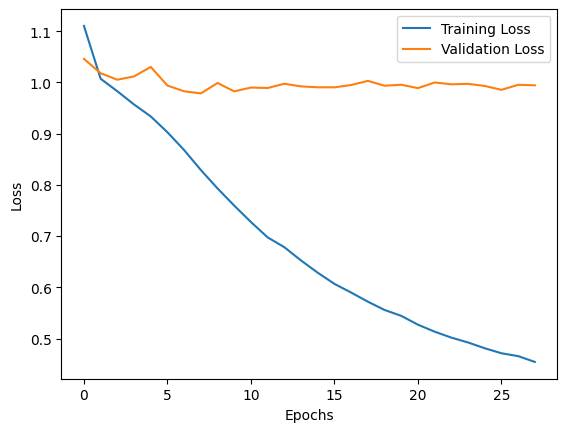

In [11]:
model_path = "smda/project/models/multimodal_model_quality.pth"

lr = best_params["lr"]
epochs = 300
weight_decay=best_params["weight_decay"]
submodel_size = best_params["submodel_size"]
fc_size = best_params["fc_size"]
batch_size = best_params["batch_size"]

title_dims = len(next(iter(title_embeddings.values())))
image_dims = len(next(iter(image_embeddings.values())))

model = MultimodalModel(
    image_input_dim=image_dims,
    text_input_dim=title_dims,
    output_dim=1,
    submodel_size=submodel_size,
    fc_size=fc_size
).to(device)

train_loader, val_loader, test_loader = create_dataloaders(df, image_embeddings, title_embeddings, batch_size=batch_size)

criterion = nn.L1Loss().to(device)

# Instantiate optimizer and early stopper
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopper = EarlyStopping(patience=20, path=model_path, verbose=True)

# Run training and plot losses
train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, verbose=True)

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

Mean Absolute Error (MAE): 0.9890
Mean Absolute Percentage Error (MAPE): 3.0262
Permutation test p-value (MAE): 0.0000


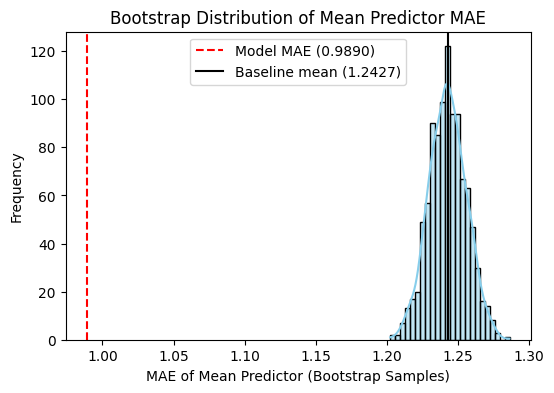

Bootstrap mean-predictor baseline MAPE: 1.2427 (95% CI: 1.2165 – 1.2691)


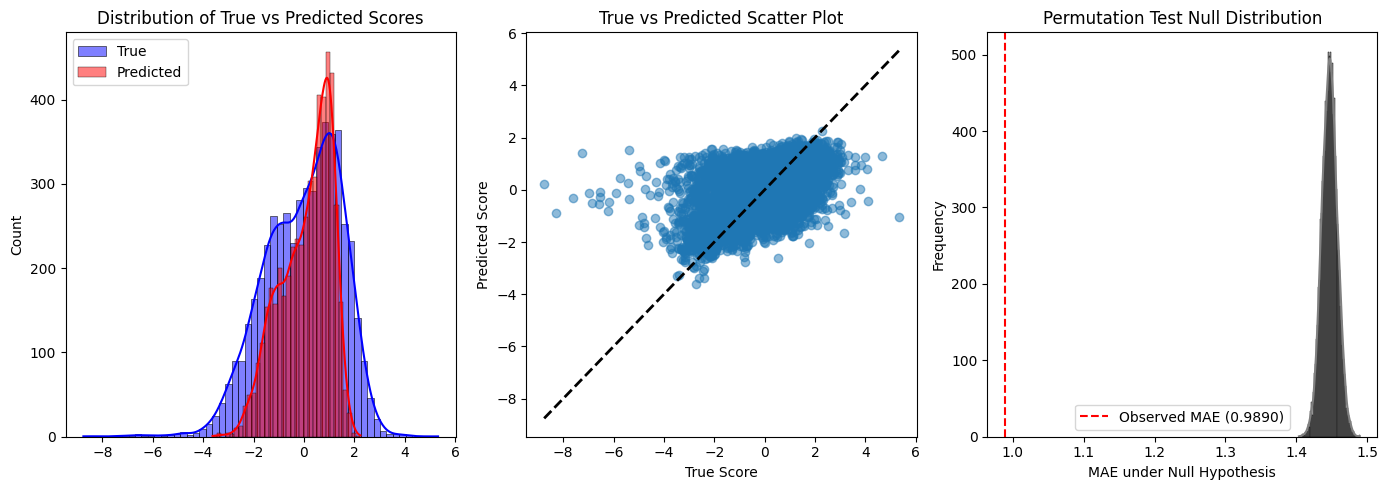

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError
from sklearn.utils import shuffle

def evaluate_model(model, data_loader, device, n_permutations=1000, verbose=True):
    model.eval()
    mae_metric = MeanAbsoluteError().to(device)
    mape_metric = MeanAbsolutePercentageError().to(device)
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for image_embedding, title_embedding, target in data_loader:
            image_embedding = image_embedding.to(device)
            title_embedding = title_embedding.to(device)
            target = target.to(device)
            output = model(image_embedding, title_embedding).view(-1)
            all_targets.append(target.cpu().numpy())
            all_preds.append(output.cpu().numpy())
            mae_metric.update(output, target)
            mape_metric.update(output, target)

    mae = mae_metric.compute().item()
    mape = mape_metric.compute().item()
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

    # Permutation Test
    permuted_maes = []
    for _ in range(n_permutations):
        perm_targets = shuffle(all_targets, random_state=None)
        perm_mae = np.mean(np.abs(all_preds - perm_targets))
        permuted_maes.append(perm_mae)

    permuted_maes = np.array(permuted_maes)
    p_value = np.mean(permuted_maes <= mae) 

    print(f"Permutation test p-value (MAE): {p_value:.4f}")
    

     # Bootstrapping     
    def bootstrap_mean_baseline(all_targets, model_mae, n_bootstrap=1000, random_state=None, plot=True):
        rng = np.random.default_rng(random_state)
        mae_scores = []
        n = len(all_targets)

        for _ in range(n_bootstrap):
            sample_idx = rng.integers(0, n, size=n)
            sample_targets = all_targets[sample_idx]
            mean_pred = np.mean(sample_targets)
            mae = np.mean(np.abs(sample_targets - mean_pred))
            mae_scores.append(mae)

        mae_scores = np.array(mae_scores)
        avg_mae = mae_scores.mean()
        ci_lower = np.percentile(mae_scores, 2.5)
        ci_upper = np.percentile(mae_scores, 97.5)

        if plot:
            plt.figure(figsize=(6, 4))
            sns.histplot(mae_scores, kde=True, color='skyblue')
            plt.axvline(model_mae, color='red', linestyle='--', label=f"Model MAE ({model_mae:.4f})")
            plt.axvline(avg_mae, color='black', linestyle='-', label=f"Baseline mean ({avg_mae:.4f})")
            plt.xlabel("MAE of Mean Predictor (Bootstrap Samples)")
            plt.ylabel("Frequency")
            plt.title("Bootstrap Distribution of Mean Predictor MAE")
            plt.legend()
            plt.show()

        return avg_mae, ci_lower, ci_upper

    avg_mae_baseline, ci_low, ci_high = bootstrap_mean_baseline(
        all_targets, model_mae=mae, n_bootstrap=1000
    )
    if verbose:
        print(f"Bootstrap mean-predictor baseline MAPE: {avg_mae_baseline:.4f} "
            f"(95% CI: {ci_low:.4f} – {ci_high:.4f})")
        
    
        # Visualization
        plt.figure(figsize=(14, 5))

        # Plot distributions of true vs predicted
        plt.subplot(1, 3, 1)
        sns.histplot(all_targets, color='blue', label='True', kde=True)
        sns.histplot(all_preds, color='red', label='Predicted', kde=True)
        plt.title('Distribution of True vs Predicted Scores')
        plt.legend()

        # True vs predicted scatter
        plt.subplot(1, 3, 2)
        plt.scatter(all_targets, all_preds, alpha=0.5)
        plt.plot([all_targets.min(), all_targets.max()],
                [all_targets.min(), all_targets.max()], 'k--', lw=2)
        plt.xlabel('True Score')
        plt.ylabel('Predicted Score')
        plt.title('True vs Predicted Scatter Plot')

        # Permutation distribution
        plt.subplot(1, 3, 3)
        sns.histplot(permuted_maes, kde=True, color='gray')
        plt.axvline(mae, color='red', linestyle='--', label=f"Observed MAE ({mae:.4f})")
        plt.xlabel('MAE under Null Hypothesis')
        plt.ylabel('Frequency')
        plt.title('Permutation Test Null Distribution')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return mae, mape, p_value, all_targets, all_preds
mae, mape, p_value, targets, preds = evaluate_model(model, test_loader, device, n_permutations=10000)